# **Data Story**

The dataset is part of a larger dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases in the US. In the US
Pima Indian women aged 21 years and older living in Phoenix, the 5th largest city in the State of Arizona
are the data used for diabetes research.
The target variable is specified as "outcome", where 1 indicates a positive diabetes test result and 0 indicates a negative result.


---
# **Problem**

You are asked to develop a machine learning model that can predict whether people have diabetes when their characteristics are specified. You are expected to perform the necessary data analysis and feature engineering steps before developing the model


---

# **Data Library**

Pregnancies: Number of pregnancies

Glucose: 2-hour plasma glucose concentration in oral glucose tolerance test

Blood Pressure: Blood Pressure (small blood pressure) (mm Hg)

SkinThickness: Skin Thickness

Insulin: 2-hour serum insulin (mu U/ml)

DiabetesPedigreeFunction: Function (2-hour plasma glucose concentration in oral
glucose tolerance test)

BMI: Body mass index

Age: Age (years)

Outcome: Have the disease (1) or not (0)


# **Inclusion of Libraries and Data & Data Shaking**

In [ ]:
#!pip install optuna
#!pip install catboost

In [ ]:
# Configurators
import logging
import warnings
from sklearn.exceptions import ConvergenceWarning
# Data & EDA
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

# Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Imputers
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Models | Metrics & Score Calculators
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn import model_selection
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import optuna
import optuna.logging as optuna_logging

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
optuna_logging.disable_default_handler()

df = pd.read_csv('diabetes.csv')

In [ ]:
shuffle_indices = np.random.permutation(len(df))
df = df.iloc[shuffle_indices]

# **Exploratory Data Analysis**

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

##################### Shape #####################

(768, 9)

##################### Types #####################

Pregnancies                   int64

Glucose                       int64

BloodPressure                 int64

SkinThickness                 int64

Insulin                       int64

BMI                         float64

DiabetesPedigreeFunction    float64

Age                           int64

Outcome                       int64

dtype: object

##################### Head #####################

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \

20             3      126             88             41      235  39.3   

579            2      197             70             99        0  34.7   

407            0      101             62              0        0  21.9   

548            1      164             82             43       67  32.8   

210            2       81             60             22        0  27.7   



     DiabetesPedigreeFunction  Age  Ou

In [ ]:
# Get column types and store them in a DataFrame
column_types_df = pd.DataFrame(df.dtypes, columns=["column_type"])

# Get unique value counts and store them in a DataFrame
unique_value_counts_df = pd.DataFrame(df.nunique(), columns=["unique_value_count"])

# Reset column names, don't keep them as index
column_types_df.reset_index(inplace=True)
unique_value_counts_df.reset_index(inplace=True)

# Merge the two DataFrames on a common column "columns"
result_df = pd.merge(column_types_df, unique_value_counts_df, on="index")

# Update column names to lowercase
result_df.columns = ["columns", "column_type", "unique_value_count"]

# Show the results
display(result_df)

,columns,column_type,unique_value_count
0,Pregnancies,int64,17
1,Glucose,int64,136
2,BloodPressure,int64,47
3,SkinThickness,int64,51
4,Insulin,int64,186
5,BMI,float64,248
6,DiabetesPedigreeFunction,float64,517
7,Age,int64,52
8,Outcome,int64,2


***Since it is not possible to have 0 in Glucose, BloodPressure, SkinThickness, Insulin, BMI values, it is understood that there are missing values.***

In [ ]:
num_cols = [col for col in df.columns if df[col].dtype in [int, float]]
cat_cols = [col for col in df.columns if df[col].dtype in [str, object]]
print(f"Numerical Column Count:{len(num_cols)}\nCategorical Column Count:{len(cat_cols)}")

Numerical Column Count:9

Categorical Column Count:0


In [ ]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    display(pd.DataFrame(dataframe[numerical_col].describe(quantiles)).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
for col in num_cols:
    num_summary(df, col)

na_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.0,0.0,0.0,1.0,1.0,2.0,3.0,4.0,5.0,7.0,9.0,10.0,13.0,17.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Glucose,768.0,120.894531,31.972618,0.0,79.0,85.0,95.0,102.0,109.0,117.0,125.0,134.0,147.0,167.0,181.0,196.0,199.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
BloodPressure,768.0,69.105469,19.355807,0.0,38.7,54.0,60.0,64.0,68.0,72.0,74.0,78.0,82.0,88.0,90.0,106.0,122.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
SkinThickness,768.0,20.536458,15.952218,0.0,0.0,0.0,0.0,8.2,18.0,23.0,27.0,31.0,35.0,40.0,44.0,51.33,99.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Insulin,768.0,79.799479,115.244002,0.0,0.0,0.0,0.0,0.0,0.0,30.5,72.2,106.0,150.0,210.0,293.0,519.9,846.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
BMI,768.0,31.992578,7.88416,0.0,21.8,23.6,25.9,28.2,30.1,32.0,33.7,35.49,37.8,41.5,44.395,50.759,67.1


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.14035,0.165,0.2194,0.259,0.3028,0.3725,0.4542,0.5637,0.687,0.8786,1.13285,1.69833,2.42


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Age,768.0,33.240885,11.760232,21.0,21.0,22.0,23.0,25.0,27.0,29.0,33.0,38.0,42.6,51.0,58.0,67.0,81.0


,count,mean,std,min,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Outcome,768.0,0.348958,0.476951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


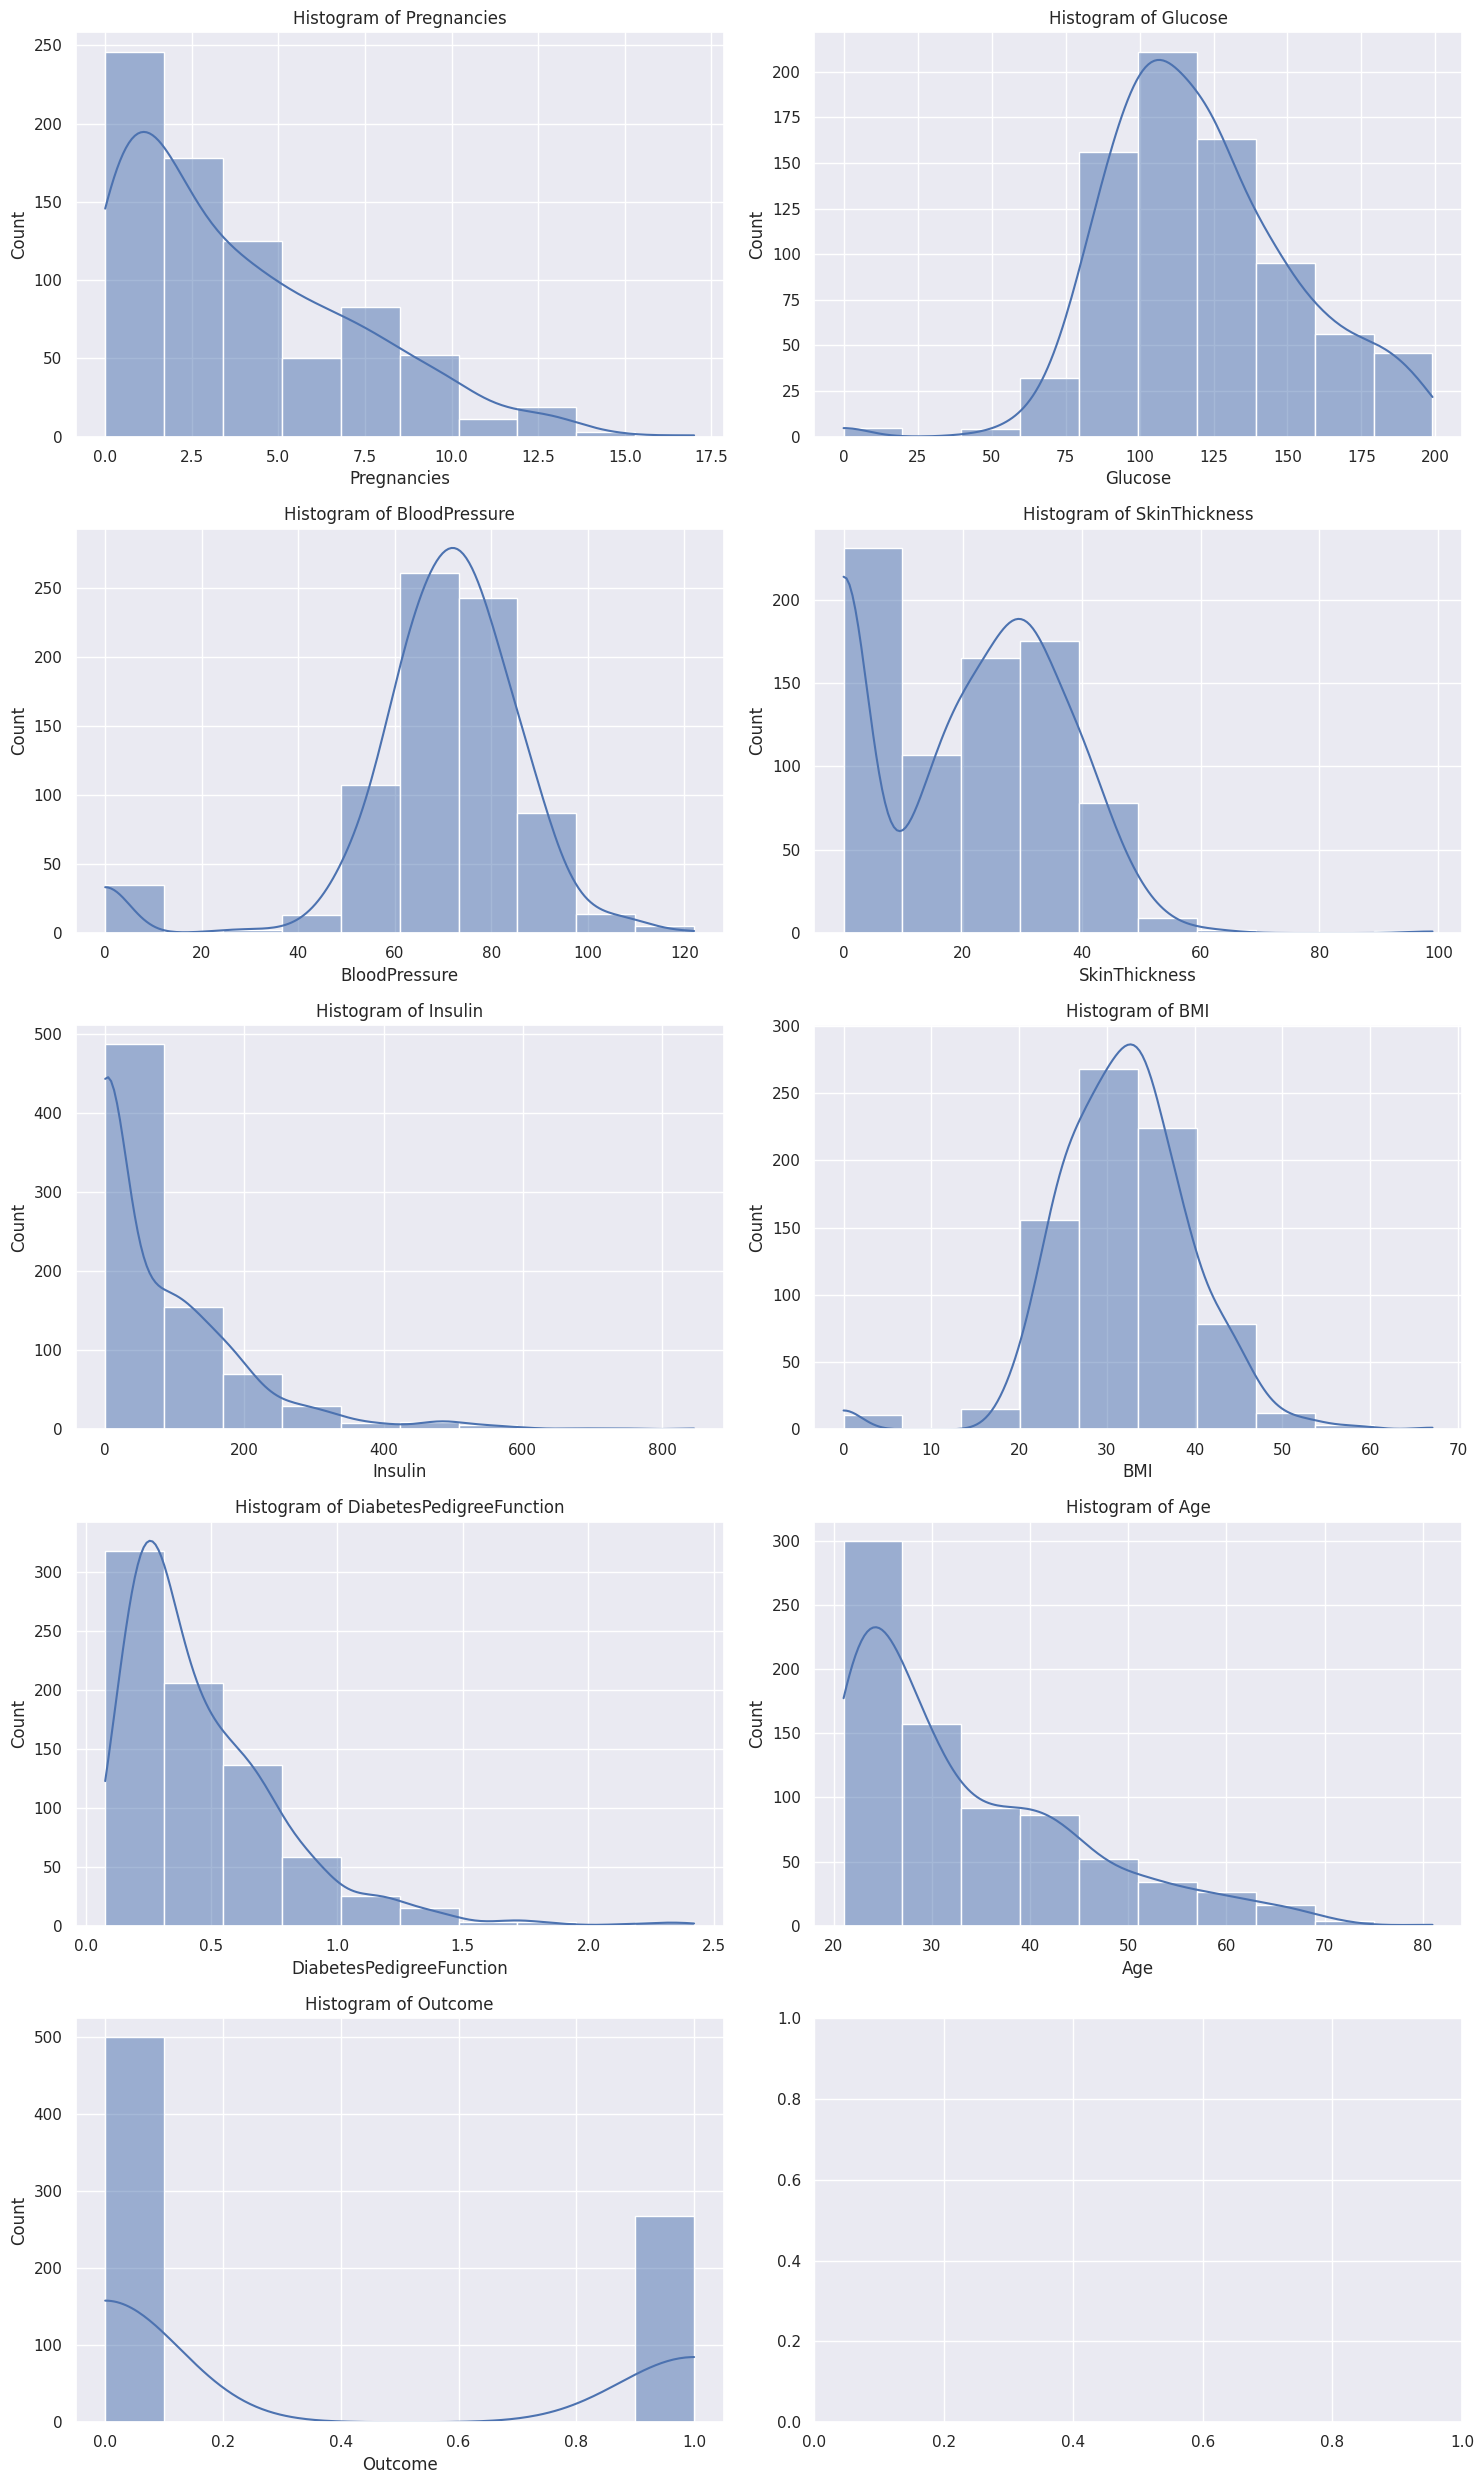

In [ ]:
def hist_plot(dataframe, num_cols, ncols=2, bins=10):
    nrows = (len(num_cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5*nrows))

    for i, col in enumerate(num_cols):
        if col in dataframe.columns:
            ax = axes[i // ncols, i % ncols]
            sns.histplot(dataframe[col], ax=ax, bins=bins, kde=True)
            ax.set_title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

hist_plot(df, num_cols)

In [ ]:
display(df.groupby('Outcome').agg('mean'))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,109.980000,68.184000,19.664000,68.792000,30.304200,0.429734,31.190000
1,4.865672,141.257463,70.824627,22.164179,100.335821,35.142537,0.550500,37.067164


## **Outlier Analysis**

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in df.columns:
    print(col, ":", check_outlier(df, col))

Pregnancies : True

Glucose : True

BloodPressure : True

SkinThickness : True

Insulin : True

BMI : True

DiabetesPedigreeFunction : True

Age : True

Outcome : False


## **Missing Value Analysis**

In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

***The values of the following columns will be changed to NaN as they cannot be 0.***

In [ ]:
print("Missing Value Counts")
for col in na_cols:
    print(col, ":", df[df[col]==0].shape[0])

Missing Value Counts

Glucose : 5

BloodPressure : 35

SkinThickness : 227

Insulin : 374

BMI : 11


## **Correlation analysis**

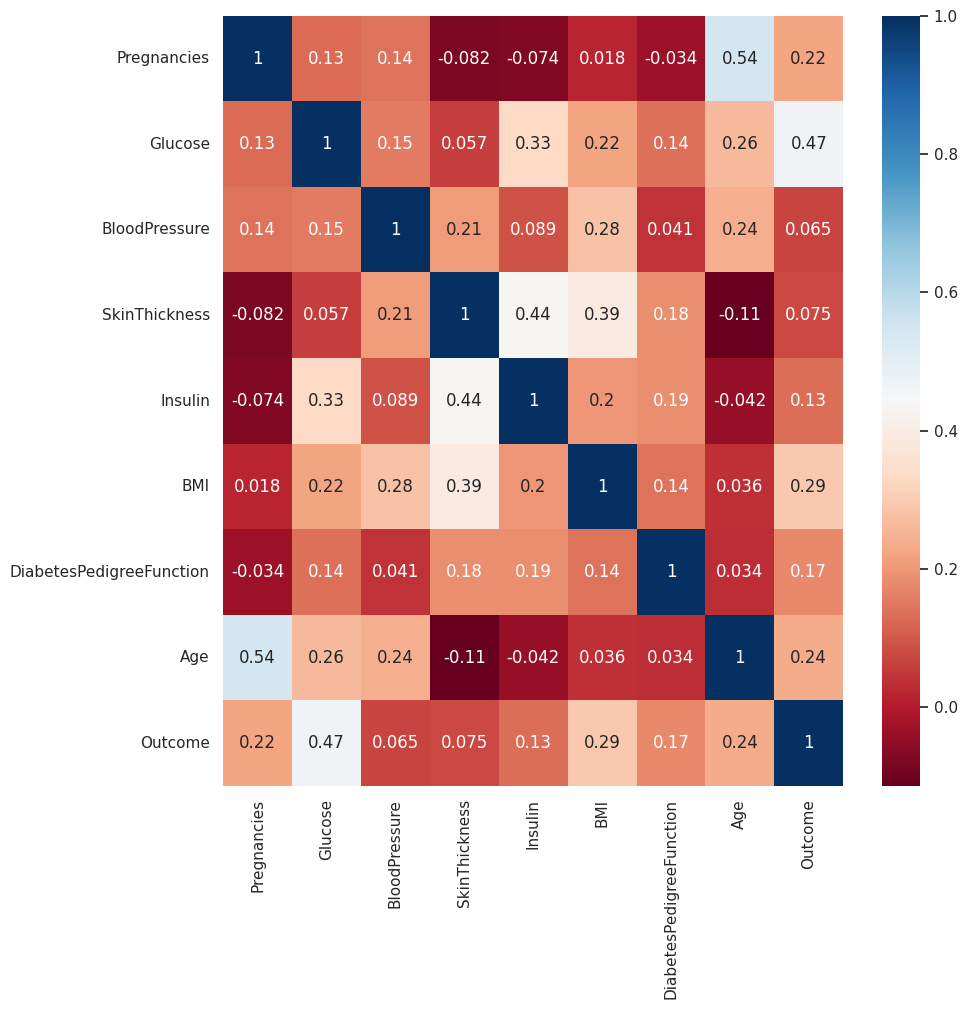

In [ ]:
corr = df.corr()
sns.set(rc={'figure.figsize': (10, 10)})
sns.heatmap(corr, cmap="RdBu", annot=True)
plt.show()

# **Feature Engineering**

### **Missing Value Handling**

In [ ]:
df[df[na_cols]==0] = np.NaN
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        display(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}))
na_columns = missing_values_table(df, na_name=True)
missing_vs_target(df, 'Outcome', na_columns)

               n_miss  ratio

Insulin           374  48.70

SkinThickness     227  29.56

BloodPressure      35   4.56

BMI                11   1.43

Glucose             5   0.65


,TARGET_MEAN,Count
Glucose_NA_FLAG,,
0,0.348624,763
1,0.400000,5


,TARGET_MEAN,Count
BloodPressure_NA_FLAG,,
0,0.343793,733
1,0.457143,35


,TARGET_MEAN,Count
SkinThickness_NA_FLAG,,
0,0.332717,541
1,0.387665,227


,TARGET_MEAN,Count
Insulin_NA_FLAG,,
0,0.329949,394
1,0.368984,374


,TARGET_MEAN,Count
BMI_NA_FLAG,,
0,0.351387,757
1,0.181818,11


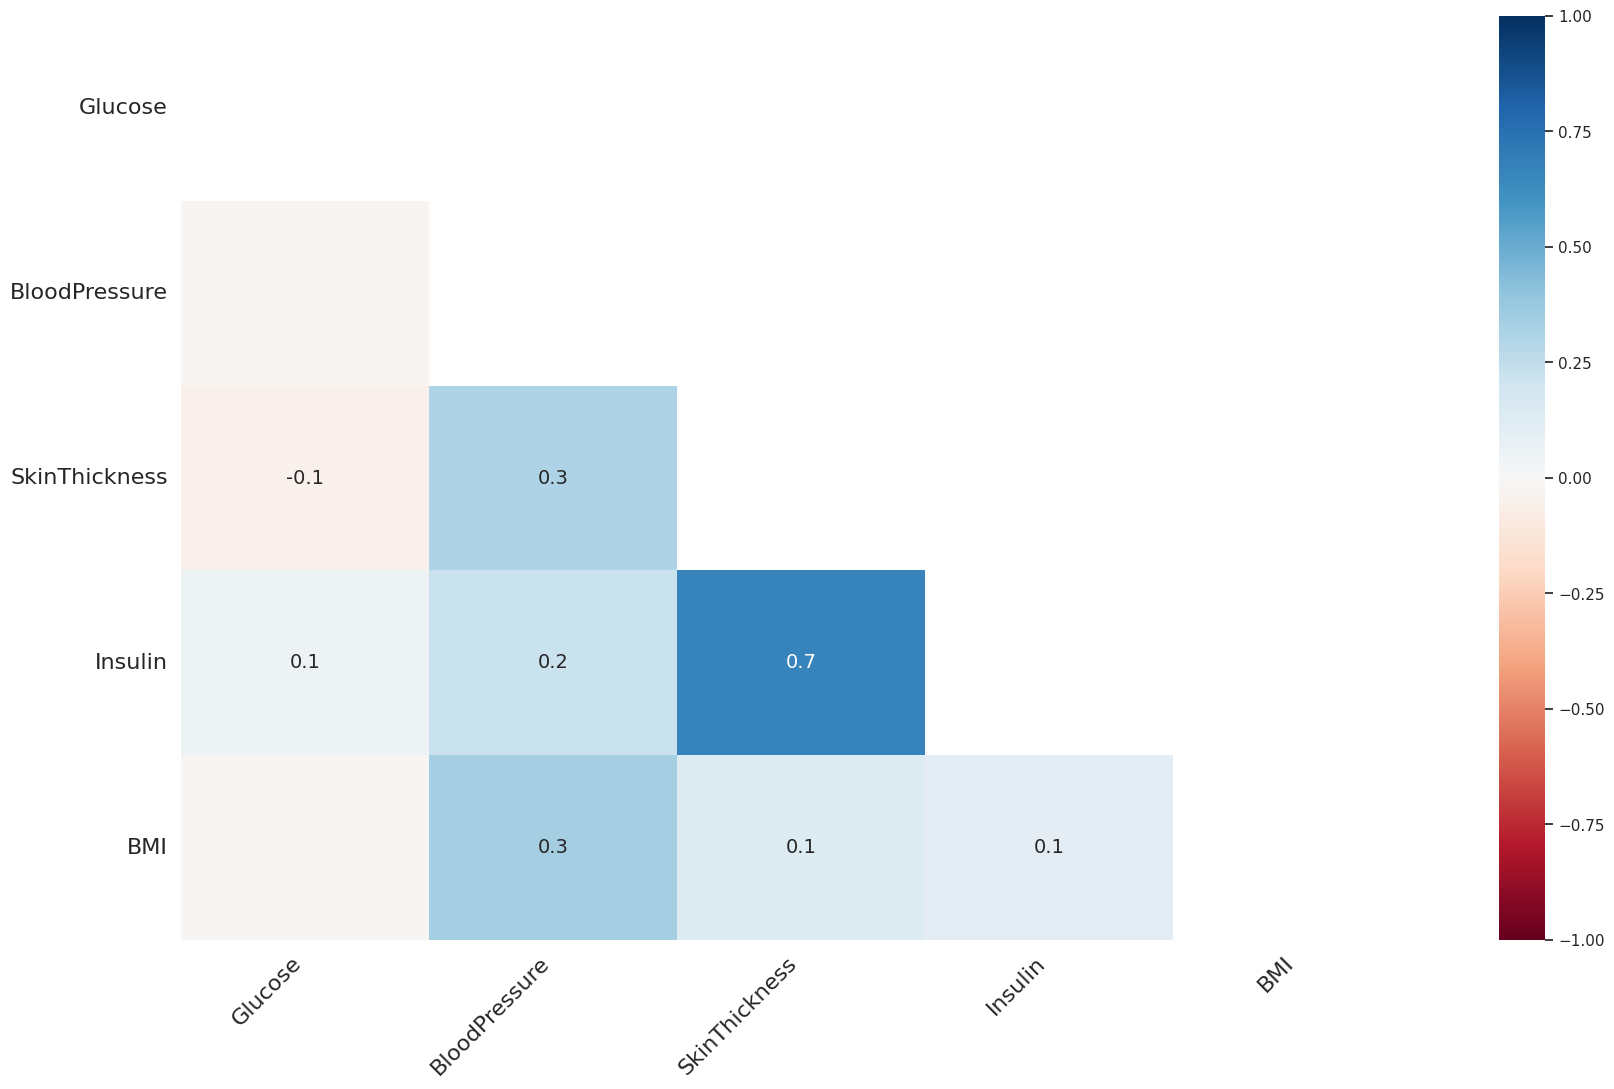

In [ ]:
msno.heatmap(df)
plt.show()

In [ ]:
class CorrImputer:
    def __init__(self, target_name, target_values):
        self.target_name = target_name
        self.target_values = target_values
        self.group_medians = {}
    def fit(self, data):
        for col in data.columns:
            if col != self.target_name:
                self.group_medians[col] = data.groupby(self.target_values)[col].transform('median')
    def transform(self, data):
        for col in data.columns:
            if col != self.target_name and col in self.group_medians:
                data[col].fillna(self.group_medians[col], inplace=True)

        return data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [ ]:
def best_imputation_method(data, target_column):
    missing_values = data.isnull().sum()
    missing_percent = (missing_values / len(data)) * 100
    missing_columns = missing_values[missing_values > 0].index.tolist()
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

    imputation_methods = {
        "Mean": SimpleImputer(strategy="mean"),
        "Median": SimpleImputer(strategy="median"),
        "Most Frequent": SimpleImputer(strategy="most_frequent"),
        "KNN": KNNImputer(n_neighbors=5),
        "Iterative": IterativeImputer(max_iter=10, random_state=0),
        'CorrImputer': CorrImputer('Outcome', df['Outcome'])
    }

    results = {}
    for column in missing_columns:
        if column in numeric_columns:
            for method_name, method in imputation_methods.items():
                missing_data = data[data[column].isnull()]

                imputed_data = data.copy()
                imputed_data[column] = method.fit_transform(imputed_data[[column]])

                performance_metric = abs(imputed_data[target_column].corr(imputed_data[column]))

                results[f"{column} - {method_name}"] = performance_metric

    variables = set([col.split(" - ")[0] for col in results.keys()])
    best_methods = {}
    for variable in variables:
        variable_results = {key: value for key, value in results.items() if key.startswith(variable)}

        best_method = max(variable_results, key=variable_results.get)
        best_methods[variable] = best_method.split(" - ")[1]
    return best_methods, imputation_methods

def impute_nulls(data, target_column):
    data = data.copy()
    best_methods, imputation_methods = best_imputation_method(data, target_column)
    print(best_methods)
    for column, method in best_methods.items():
        data[column] = imputation_methods[method].fit_transform(data[[column]])

target_column = "Outcome"
impute_nulls(df, target_column)

{'BMI': 'CorrImputer', 'Glucose': 'CorrImputer', 'SkinThickness': 'CorrImputer', 'Insulin': 'CorrImputer', 'BloodPressure': 'CorrImputer'}


In [ ]:
df[['Insulin','BloodPressure','SkinThickness','Glucose','BMI']] = CorrImputer(target_column, df[target_column]).fit_transform(df[['Insulin','BloodPressure','SkinThickness','Glucose','BMI']])

### **Outlier Handling**

In [ ]:
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
20,3,126.0,88.0,41.0,235.0,39.3,0.704,27,0
579,2,197.0,70.0,99.0,169.5,34.7,0.575,62,1
407,0,101.0,62.0,27.0,102.5,21.9,0.336,25,0
548,1,164.0,82.0,43.0,67.0,32.8,0.341,50,0
210,2,81.0,60.0,22.0,102.5,27.7,0.290,25,0


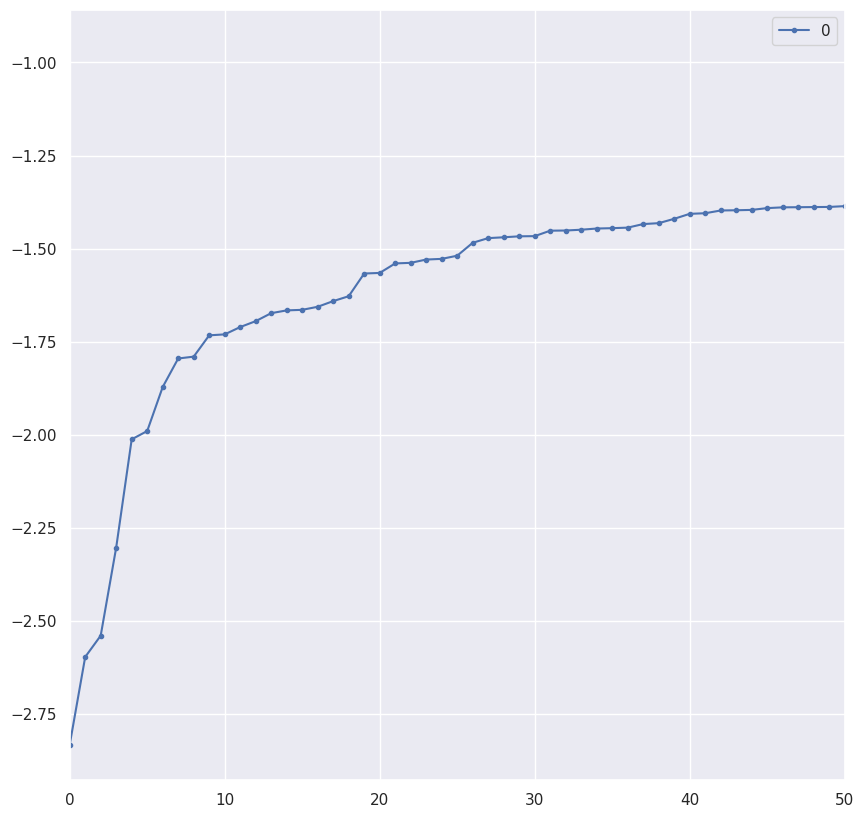

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [ ]:
th = np.sort(df_scores)[5]
df[df_scores < th].index
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)

### **Feature Extraction**

*The results of the OGTT as a screening test for type 2 diabetes can be interpreted as follows:*

*The 2-hour plasma glucose **level < 140 mg/dL** is considered normal*

*The 2-hour plasma glucose **level of 140-199 mg/dL** indicates impaired glucose tolerance*

*The 2-hour plasma glucose **level ≥ 200 mg/dL** indicates diabetes*

https://www.ncbi.nlm.nih.gov/books/NBK532915/#:~:text=The%20results%20of%20the%20OGTT,200%20mg%2FdL%20indicates%20diabetes

In [ ]:
df["GLUCOSE_CAT"] = pd.cut(df["Glucose"], bins=[0, 140, 199, float("inf")], labels=[1, 2, 3]).astype(float)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GLUCOSE_CAT
20,3,126.0,88.0,41.0,235.0,39.3,0.704,27,0,1.0
579,2,197.0,70.0,99.0,169.5,34.7,0.575,62,1,2.0
407,0,101.0,62.0,27.0,102.5,21.9,0.336,25,0,1.0
548,1,164.0,82.0,43.0,67.0,32.8,0.341,50,0,2.0
210,2,81.0,60.0,22.0,102.5,27.7,0.290,25,0,1.0


**Insulin Value Grouping**

Created by using this grouping

In a healthy person, the blood sugar level after two hours is usually **less than 7.8 mmol/L (140 mg/dl)**.

A blood sugar level **between 7.8 and 11.0 mmol/dl (140 to 197 mg/dl)**, however, indicates impaired glucose tolerance.

If the level is **over 11.1 mmol/dl (200 mg/dl)**, diabetes mellitus is diagnosed.

https://www.news-medical.net/health/Insulin-Resistance-Diagnosis.aspx

In [ ]:
df["INSULIN_CAT"] = pd.cut(df["Insulin"], bins=[0, 139, 199, float("inf")], labels=[1, 2, 3]).astype(float)

**Body Mass Index Grouping**

BMI values **less than 18.5 kg/m²** are considered underweight.

BMI values **from 18.5 kg/m² to 24.9 kg/m²** are healthy.

Overweight is defined as a body mass index of **25.0 to less than 30.0 kg/m²**.
People with BMIs in this range have an increased risk of type 2 diabetes,
hypertension, and cardiovascular disease.

Obesity is defined as a BMI of 30.0 kg/m² or greater. People with BMIs of **30 kg/m² or more** are at higher risk of cardiovascular diseases.

Extreme obesity is defined as a BMI of **40 kg/m² or greater**.

https://www.heart.org/en/healthy-living/healthy-eating/losing-weight/bmi-in-adults

In [ ]:
df['BMI_CAT'] = pd.cut(df["BMI"], bins=[0,18.5,24.9, 29.9, 30, 40, float("inf")], labels=[1, 2, 3, 4, 5, 6]).astype(float)

**Age Ranges**


In [ ]:
df["AGE_CAT"] = pd.cut(df["Age"], bins=[0,24,34,44,54,59,64,74,84,85, float("inf")], labels=[1,2,3,4,5,6,7,8,9,10]).astype(float)

## **Standardization**

In [ ]:
def select_best_scaler(data, scaler_list, target_variable):
    results = {}

    for scaler in scaler_list:
        transformed_data = scaler.fit_transform(data)
        sample_model = KNeighborsClassifier()
        sample_model.fit(transformed_data, target_variable)
        accuracy = sample_model.score(transformed_data, target_variable)
        results[scaler] = accuracy

    best_scaler_name = max(results, key=results.get)

    return best_scaler_name

scaler_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]
best_scaler = select_best_scaler(df, scaler_list, df['Outcome'])
print("Best scaler:", best_scaler)
num_cols = df.select_dtypes(include=[int, float]).columns
df[num_cols] = best_scaler.fit_transform(df[num_cols])
print(f"{best_scaler} applied.")

Best scaler: MinMaxScaler()

MinMaxScaler() applied.


In [ ]:
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GLUCOSE_CAT,INSULIN_CAT,BMI_CAT,AGE_CAT
20,0.176471,0.529032,0.653061,0.369565,0.265625,0.431493,0.267293,0.100000,0.0,0.0,1.0,0.8,0.142857
579,0.117647,0.987097,0.469388,1.000000,0.186899,0.337423,0.212212,0.683333,1.0,1.0,0.5,0.8,0.714286
407,0.000000,0.367742,0.387755,0.217391,0.106370,0.075665,0.110162,0.066667,0.0,0.0,0.0,0.2,0.142857
548,0.058824,0.774194,0.591837,0.391304,0.063702,0.298569,0.112297,0.483333,0.0,1.0,0.0,0.8,0.428571
210,0.117647,0.238710,0.367347,0.163043,0.106370,0.194274,0.090521,0.066667,0.0,0.0,0.0,0.4,0.142857


# **Model Setup & Evaluation**

In [ ]:
X = df.drop(columns="Outcome")
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

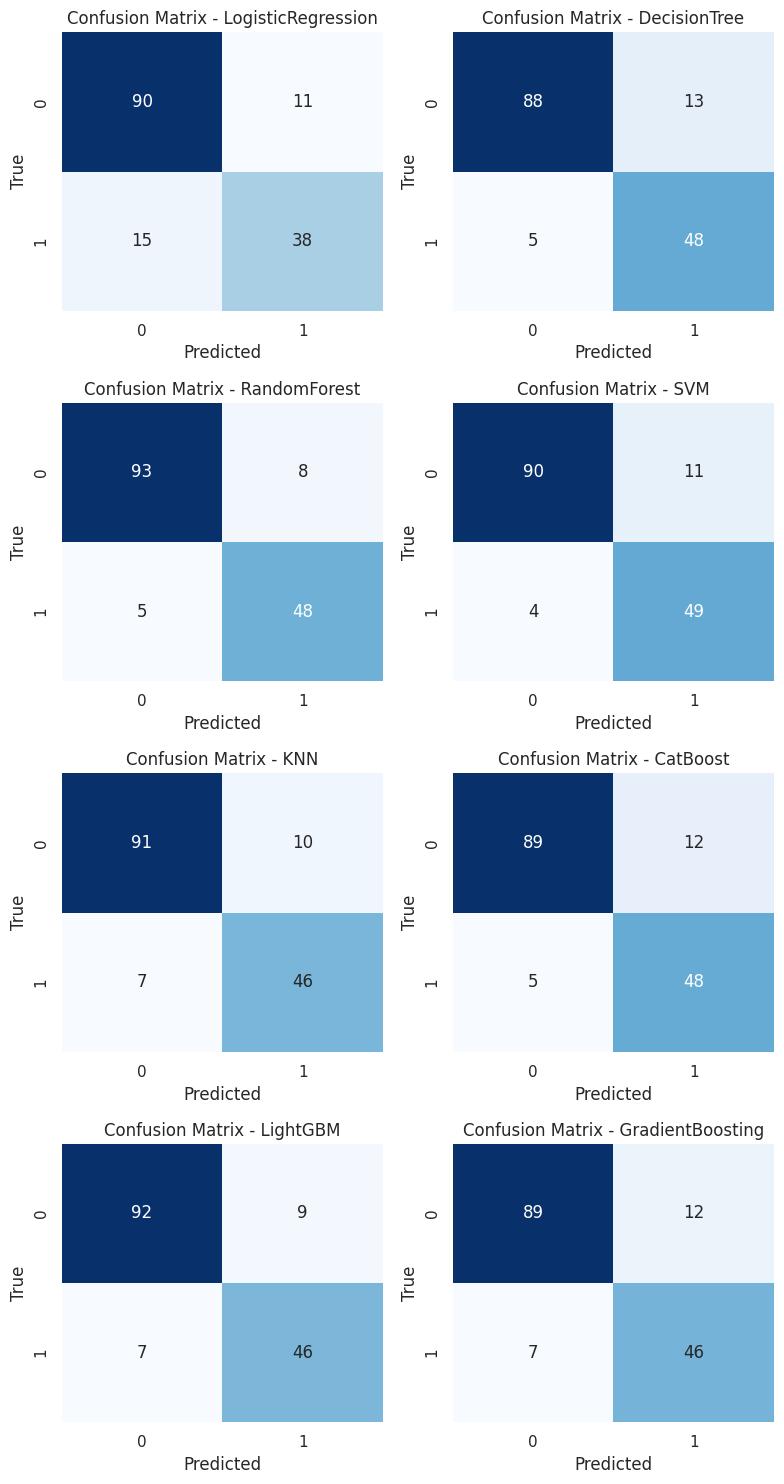

,Accuracy,Precision,Recall,F1 Score,K-Folds Score
RandomForest,0.915584,0.917373,0.915584,0.916110,0.891849
SVM,0.902597,0.908996,0.902597,0.903866,0.861910
LightGBM,0.896104,0.897311,0.896104,0.896546,0.880092
KNN,0.889610,0.891698,0.889610,0.890297,0.846258
CatBoost,0.889610,0.896284,0.889610,0.891048,0.880109
DecisionTree,0.883117,0.891395,0.883117,0.884808,0.846292
GradientBoosting,0.876623,0.880973,0.876623,0.877836,0.887970
LogisticRegression,0.831169,0.829049,0.831169,0.829498,0.800735


In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {model_name}')

def model(df, test_size=0.2, random_state=42):

    models = {
        'LogisticRegression': LogisticRegression(max_iter=3000, solver='lbfgs'),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'CatBoost': CatBoostClassifier(verbose=False),
        'LightGBM': lgb.LGBMClassifier(),
        'GradientBoosting': GradientBoostingClassifier()
    }

    results = {}

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 15))
    axes = axes.flatten()
    results = {}

    for i, (model_name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        k_folds = KFold(n_splits = 10)
        k_folds_score = cross_val_score(model, X, y, cv = k_folds).sum()/10
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'K-Folds Score': k_folds_score
        }

        plot_confusion_matrix(y_test, y_pred, model_name, axes[i])

    plt.tight_layout()
    plt.show()

    return results

def model_to_dataframe(df, test_size=0.2, random_state=42):
    results = model(df, test_size, random_state)
    result_df = pd.DataFrame(results).T
    result_df = result_df.sort_values(by='Accuracy', ascending=False)
    return result_df

model_to_dataframe(df)

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
    }

    model = GradientBoostingClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best Parameters:", study.best_params)
print("Best Model Score:", study.best_value)

Best Parameters: {'n_estimators': 80, 'learning_rate': 0.05939107691879611, 'max_depth': 8}

Best Model Score: 0.07792207792207792


In [ ]:
# Best Parameters: {'n_estimators': 80, 'learning_rate': 0.05939107691879611, 'max_depth': 8}
model = GradientBoostingClassifier(**study.best_params).fit(X_train, y_train)
print(model.score(X_test,y_test))

0.922077922077922

In [ ]:
k_folds = KFold(n_splits = 10)
k_folds_score = cross_val_score(model, X, y, cv = k_folds).sum()/10
print(k_folds_score)

0.8710013670539987


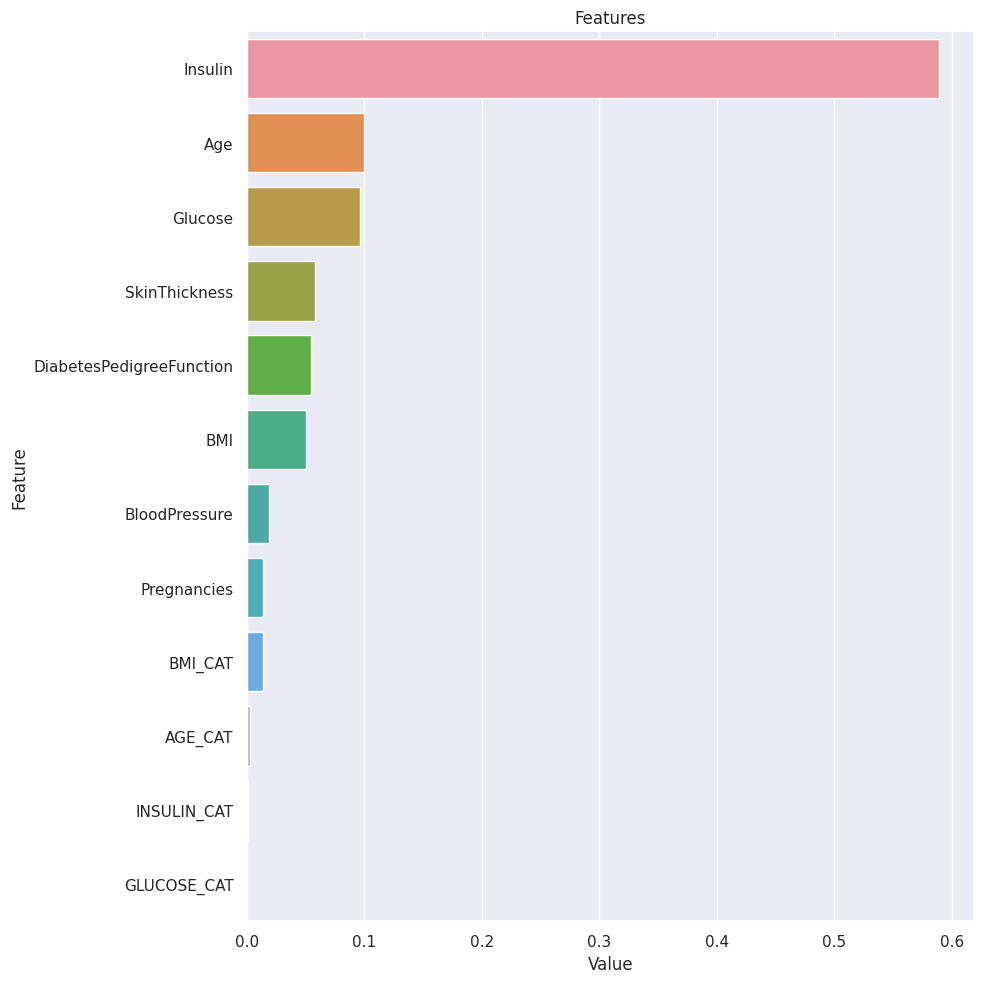

In [ ]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
plot_importance(model, X)

**Saving the Data and ML Model**

In [ ]:
import joblib
df.to_csv('diabetes_06-08-2023.csv', index=False)
joblib.dump(model, 'diabetes_model.pkl')

['diabetes_model.pkl']

**Getting Same Accuracy**

In [ ]:
last_df = pd.read_csv('diabetes_06-08-2023.csv')
X = last_df.drop(columns="Outcome")
y = last_df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = GradientBoostingClassifier(n_estimators=80, learning_rate=0.05939107691879611, max_depth=8).fit(X_train, y_train)
print("Model Score:",model.score(X_test,y_test))
k_folds = KFold(n_splits = 10)
k_folds_score = cross_val_score(model, X, y, cv = k_folds).sum()/10
print("K-Folds Score:",k_folds_score)

Model Score: 0.9285714285714286

K-Folds Score: 0.8748974709501024
